<em><b>10/ 09/ 2021 UPDATE</b></em>
* Drop column 25%_price and 75%_price
* Change column name from '50%_price' to 'median_price'
* Manually impute na values in 'sales_no', 'median_price', 'mean_price' > <b><u>impute method open to discussion<u></b>
    * sales_no: impute with 5
    * median_price: **median** of 'median_price' of same dwelling_type of the same quarter
    * mean_price: **median** of 'mean_price' of same dwellling_type of the same quarter
* Group income in to three buckets -> <u><b>open to discussion</b></u>
    * LOW: less than \\$800 pw
    * MEDIUM: \\$800 - \\$1749 pw
    * HIGH: greater or equal to \\$1750 pw
    
        * information on 2020 avg. weekly income from ABS [(here)](https://www.abs.gov.au/statistics/labour/earnings-and-work-hours/average-weekly-earnings-australia/latest-release)
        * [NSW 'very low to moderate income' definition](https://www.facs.nsw.gov.au/providers/housing/affordable/about/chapters/who-are-very-low-to-moderate-income-earners)
        * [National minimum wage](https://www.fairwork.gov.au/pay/minimum-wages#national): \\$20.33 per hour or \\$772 pw
    


Thought:
* Dropt the four delta columns too? Or is it needed for plotting growth?
* Seems a lot of work to map postcode to LGA - should we just use the LGA tab instead? (most geographical data on ABS is based on LGA, i couldn't find clean and easy-to-use LGA to POA mapping, for the sake of visualisation etc. it might be easier to base our analysis on LGA)

### DISCUSSION POINT: ###

IF TO USE THIS HOUSING DATA
1. **Use postcode or LGA** - LGA usually covers larger area than one postcode, which might mean less pointy data, but makes better sense to readers; on the other hand one postcode corresponds to multiple suburbs, can be hard to describe (below preliminary analysis was done using postcode for simplicity). 
Postcode to LGA Mapping [here](https://www.dva.gov.au/sites/default/files/Providers/nsworp.pdf).


2. **Limit to Sydney Region or whole NSW** - the dataset contains data for all NSW regions (central coast, Wollogong etc.). Are we going to limit our analysis to Greater Syndey Region only or not? If so, need to figure out a method tease out Sydney LGAs / postcodes - scraping some gov. table (above mapping for example) and use the join method.


3. **What variables from census to inclue and how** intuitively income, employment status, age, household size etc. We can merge in the master df and use RFE to decide which one is relevant. But the problem is - census data is categorical, you'll see what I mean by look at the example below of income - each bucket is one column, how to do modellilng using these bucket-level variables?

    One thought: calculate a rough 'average_income' of each postcode/ LGA, i.e SUM(% of each bucket * bucket value), bucket will have to be assigned by us, e.g. the AUD1000-1249 per week will have a bucket value of 1125 (the middle point)

**DATA SOURCE:**

[NSW Housing Rent and Sales](https://www.facs.nsw.gov.au/resources/statistics/rent-and-sales/back-issues)

Sales data - renamed vs. original variable names:
* <b>dwelling_type</b>: Dwelling Type
* <b>25%_price</b>: First Quartile Sales Price (AUD 000s)
* <b>median_price</b>: Median Sales Price (AUD 000s)
* <b>75%_price</b>: Third Quartile Sales Price (AUD 000s)
* <b>mean_prce</b>: Mean Sales Price (AUD 000s)
* <b>sales_no</b>: Number of Sales
* <b>Qdelta_median</b>: Qtly change in Median
* <b>Adelta_median</b>: Annual change in Median
* <b>Qdelta_count</b>: Qtly change in Count
* <b>Adelta_count</b>: Annual change in Count

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Sales Data

### 1-1. Data cleaning and preparation

**CR**: could possibly use a loop to do the below. I've got some code from another notebook that can do this. 

In [2]:
s136 = "Files/Sales/Issue-136-Sales-tables-March-2021-quarter.xlsx"
s135 = "Files/Sales/Issue-135-Sales-tables-December-2020-quarter.xlsx"
s134 = "Files/Sales/Issue-134-Sales-tables-September-2020-quarter.xlsx"
s133 = "Files/Sales/Issue-133-Sales-tables-June-2020-quarter.xlsx"
s132 = "Files/Sales/Issue-132-Sales-tables-March-2020-quarter.xlsx"
s131 = "Files/Sales/Issue-131-Sales-tables-December-quarter-2019.xlsx"
s130 = "Files/Sales/Issue-130-Sales-tables-September-quarter-2019.xlsx"
s129 = "Files/Sales/Issue-129-Sales-tables-June-quarter-2019.xlsx"
s128 = "Files/Sales/Issue-128-Sales-tables-Mar-quarter-2019.xlsx"

# Read the two sheets into two separate dataframes
s136 = pd.read_excel(s136, sheet_name="Postcode", na_values='-', header=6)
s135 = pd.read_excel(s135, sheet_name="Postcode", na_values='-', header=6)
s134 = pd.read_excel(s134, sheet_name="Postcode", na_values='-', header=6)
s133 = pd.read_excel(s133, sheet_name="Postcode", na_values='-', header=6)
s132 = pd.read_excel(s132, sheet_name="Postcode", na_values='-', header=6)
s131 = pd.read_excel(s131, sheet_name="Postcode", na_values='-', header=6)
s130 = pd.read_excel(s130, sheet_name="Postcode", na_values='-', header=5)
s129 = pd.read_excel(s129, sheet_name="Postcode", na_values='-', header=4)
s128 = pd.read_excel(s128, sheet_name="Postcode", na_values='-', header=4)

# Sale prices in any geographical area where the number of sales is 10 or less were not shown for confidentiality
# They were represented as '-' in the table

print("Q1 2021(s136):", s136.shape,"\n",
      "Q4 2020(s135):", s135.shape,"\n",
      "Q3 2020(s134):", s134.shape,"\n",
      "Q2 2020(s133):", s133.shape,"\n",
      "Q1 2020(s132):", s132.shape,"\n",
      "Q4 2019(s131):", s131.shape,"\n",
      "Q3 2019(s130):", s130.shape,"\n",
      "Q2 2019(s129):", s129.shape,"\n",
      "Q1 2019(s128):", s128.shape)

Q1 2021(s136): (1427, 11) 
 Q4 2020(s135): (1459, 11) 
 Q3 2020(s134): (1419, 11) 
 Q2 2020(s133): (1332, 11) 
 Q1 2020(s132): (1361, 11) 
 Q4 2019(s131): (1382, 11) 
 Q3 2019(s130): (1377, 11) 
 Q2 2019(s129): (1356, 11) 
 Q1 2019(s128): (1332, 11)


In [3]:
# Add time period and key columns before merging

s136['key'] = 's136'
s135['key'] = 's135'
s134['key'] = 's134'
s133['key'] = 's133'
s132['key'] = 's132'
s131['key'] = 's131'
s130['key'] = 's130'
s129['key'] = 's129'
s128['key'] = 's128'

s136['time_period'] = '2021 Q1'
s135['time_period'] = '2020 Q4'
s134['time_period'] = '2020 Q3'
s133['time_period'] = '2020 Q2'
s132['time_period'] = '2020 Q1'
s131['time_period'] = '2019 Q4'
s130['time_period'] = '2019 Q3'
s129['time_period'] = '2019 Q2'
s128['time_period'] = '2019 Q1'

s136['year'] = '2021'
s135['year'] = '2020'
s134['year'] = '2020'
s133['year'] = '2020'
s132['year'] = '2020'
s131['year'] = '2019'
s130['year'] = '2019'
s129['year'] = '2019'
s128['year'] = '2019'

s136['quarter'] = '1'
s135['quarter'] = '4'
s134['quarter'] = '3'
s133['quarter'] = '2'
s132['quarter'] = '1'
s131['quarter'] = '4'
s130['quarter'] = '3'
s129['quarter'] = '2'
s128['quarter'] = '1'

In [4]:
# Merge sales file into one master file
frames = [s128, s129, s130, s131, s132, s133, s134, s135, s136]
s_master = pd.concat(frames)

# Check master sales data's shape and dtypes
print("s_master:", s_master.shape, "\n")
print(s_master.dtypes)

s_master: (12445, 15) 

Postcode                                int64
Dwelling Type                          object
First Quartile Sales Price\n$'000s    float64
Median Sales Price\n$'000s            float64
Third Quartile Sales Price\n'000s     float64
Mean Sales Price\n$'000s              float64
Sales\nNo.                             object
Qtly change in Median                 float64
Annual change in Median               float64
Qtly change in Count                  float64
Annual change in Count                float64
key                                    object
time_period                            object
year                                   object
quarter                                object
dtype: object


In [5]:
# Rename column for easier referencing
rename_cols= {'Postcode':'postcode', 
             'Dwelling Type':'dwelling_type', 
             "First Quartile Sales Price\n$'000s" : '25%_price',
             "Median Sales Price\n$'000s" : 'median_price', 
             "Third Quartile Sales Price\n'000s" : '75%_price',
             "Mean Sales Price\n$'000s" : 'mean_price',
             'Sales\nNo.':'sales_no',
             'Qtly change in Median':'Qdelta_median',
             'Annual change in Median':'Adelta_median',
             'Qtly change in Count':'Qdelta_count',
             'Annual change in Count':'Adelta_count'}

s_master.rename(columns=rename_cols, inplace=True)

# Drop unwanted columns
s_master = s_master.drop(columns=['25%_price', '75%_price'], axis=1)

s_master.head(5)

,postcode,dwelling_type,median_price,mean_price,sales_no,Qdelta_median,Adelta_median,Qdelta_count,Adelta_count,key,time_period,year,quarter
0,2000,Total,1160.0,1348.0,103,-0.0169,-0.1375,-0.1043,-0.1488,s128,2019 Q1,2019,1
1,2000,Non Strata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s128,2019 Q1,2019,1
2,2000,Strata,1135.0,1322.0,101,-0.0340,-0.0920,-0.0734,-0.1062,s128,2019 Q1,2019,1
3,2007,Total,641.0,517.0,s,-0.0642,-0.1097,-0.1333,-0.3158,s128,2019 Q1,2019,1
4,2007,Strata,641.0,517.0,s,-0.0642,-0.1097,-0.1333,-0.3158,s128,2019 Q1,2019,1


Note that each postcode has 3 rows - Total, Strata, and Non-Strata. We'll later separate them into three dataframes.

In [6]:
# Impute na  

# na in 'sales_no': repace with 5 (median of 0 and 10)
s_master.loc[s_master['sales_no'].isnull(), 'sales_no'] = 5.0
s_master['sales_no'].isnull().any()

False

In [7]:
# na in 'median_price': replace with median of 'median_place' of the same dwelling_type of the same quarter
keys = list(s_master['key'].unique())

# Total
for k in keys:
    k_imp = s_master.loc[(s_master['median_price'].notna()) & 
                         (s_master['dwelling_type']=='Total') &
                         (s_master['key']==k),
                         'median_price'].median() # calculate imputer value 
    
    s_master.loc[(s_master['median_price'].isnull()) & 
                 (s_master['dwelling_type']=='Total') &
                 (s_master['key']==k),
                 'median_price']=k_imp #impute
    
# Strata
for k in keys:
    k_imp = s_master.loc[(s_master['median_price'].notna()) & 
                         (s_master['dwelling_type']=='Strata') &
                         (s_master['key']==k),
                         'median_price'].median()
    
    s_master.loc[(s_master['median_price'].isnull()) & 
                 (s_master['dwelling_type']=='Strata') &
                 (s_master['key']==k),
                 'median_price']=k_imp

# Non-Strata
for k in keys:
    k_imp = s_master.loc[(s_master['median_price'].notna()) & 
                         (s_master['dwelling_type']=='Non Strata') &
                         (s_master['key']==k),
                         'median_price'].median()
    
    s_master.loc[(s_master['median_price'].isnull()) & 
                 (s_master['dwelling_type']=='Non Strata') &
                 (s_master['key']==k),
                 'median_price']=k_imp

s_master['median_price'].isnull().any()

False

In [8]:
# na in 'mean_price': replace with median of 'mean_price' of the same dwelling_type of the same quarter

# Total
for k in keys:
    k_imp = s_master.loc[(s_master['mean_price'].notna()) & 
                         (s_master['dwelling_type']=='Total') &
                         (s_master['key']==k),
                         'median_price'].median() # calculate imputer value 
    
    s_master.loc[(s_master['mean_price'].isnull()) & 
                 (s_master['dwelling_type']=='Total') &
                 (s_master['key']==k),
                 'mean_price']=k_imp #impute
    
# Strata
for k in keys:
    k_imp = s_master.loc[(s_master['mean_price'].notna()) & 
                         (s_master['dwelling_type']=='Strata') &
                         (s_master['key']==k),
                         'mean_price'].median()
    
    s_master.loc[(s_master['mean_price'].isnull()) & 
                 (s_master['dwelling_type']=='Strata') &
                 (s_master['key']==k),
                 'mean_price']=k_imp

# Non-Strata
for k in keys:
    k_imp = s_master.loc[(s_master['mean_price'].notna()) & 
                         (s_master['dwelling_type']=='Non Strata') &
                         (s_master['key']==k),
                         'mean_price'].median()
    
    s_master.loc[(s_master['mean_price'].isnull()) & 
                 (s_master['dwelling_type']=='Non Strata') &
                 (s_master['key']==k),
                 'mean_price']=k_imp
    
s_master['mean_price'].isnull().any()

False

In [9]:
s_master.isnull().sum()

postcode            0
dwelling_type       0
median_price        0
mean_price          0
sales_no            0
Qdelta_median    3521
Adelta_median    3526
Qdelta_count     3521
Adelta_count     3526
key                 0
time_period         0
year                0
quarter             0
dtype: int64

Sales number was read into the dataframe as string because accordingly to the Explanatory note "statistics calculated from sample sizes between 10 and 30 are shown by an ‘s’ in the relevant table.  We suggest these data are treated with caution, particularly when assessing quarterly and annual changes."

In [10]:
# Replace 's' with the median of 10 and 30 since there're quite a few
s_master.loc[s_master['sales_no'] == 's', 'sales_no'] = 20.0

# Cast type as float
s_master['sales_no'] = s_master['sales_no'].astype(float)

s_master.describe().round(2)

,postcode,median_price,mean_price,sales_no,Qdelta_median,Adelta_median,Qdelta_count,Adelta_count
count,12445.00,12445.00,12445.00,12445.00,8924.00,8919.00,8924.00,8919.00
mean,2373.63,839.16,903.37,41.47,0.03,0.05,0.17,0.24
std,256.64,567.54,658.89,48.35,0.46,0.45,0.71,0.77
min,2000.00,80.00,110.00,5.00,-0.97,-0.97,-0.72,-0.80
25%,2145.00,601.00,626.00,5.00,-0.04,-0.05,-0.17,-0.14
50%,2324.00,710.00,733.00,20.00,0.02,0.04,0.04,0.10
75%,2572.00,868.00,942.00,54.00,0.08,0.12,0.32,0.41
max,3691.00,17500.00,15897.00,418.00,29.04,26.13,32.00,13.00


In [11]:
# Separate dwelling types
s_total = s_master.loc[s_master['dwelling_type']=='Total']
s_strata = s_master.loc[s_master['dwelling_type']=='Strata']
s_nstrata = s_master.loc[s_master['dwelling_type']=='Non Strata']

print('Total:', s_total.shape,"\n",
     'Strata:', s_strata.shape,"\n",
     'Non Strata:', s_nstrata.shape)

Total: (4793, 13) 
 Strata: (2893, 13) 
 Non Strata: (4759, 13)


### 1-2 Exploratory and descriptive analysis

#### A. <u>Total level trends - Number of houses sold</u> ####

Key observations:
* Total sales started decline in Q1 2020 when COVID first struck, reaching a low point in Jun-20
* However, bounce back was quick to come in Q3'20 and achieved a 100% growth vs. SQLY in Q4'20

To investigate more:
* Difference between Strata and Non-Strata houses - *Strata property are mostly apartment and townhouse; while non-Strata are more likely to be houses - will explain more in the price section*
* Calculate quarter-on-quarter growth rate -> show off of skills hehee

In [12]:
# Look at total number of sales by quarter and dwelling type
sales_num = s_master.groupby(['time_period', "dwelling_type"])['sales_no'].sum().unstack()

sales_num['Strata%'] = sales_num['Strata'] / sales_num['Total'] * 100
sales_num['Non Strata%'] = sales_num['Non Strata'] / sales_num['Total'] * 100

sales_num.round(2)

dwelling_type,Non Strata,Strata,Total,Strata%,Non Strata%
time_period,,,,,
2019 Q1,13266.0,5838.0,18824.0,31.01,70.47
2019 Q2,17052.0,8438.0,25158.0,33.54,67.78
2019 Q3,17857.0,9894.0,27559.0,35.90,64.80
2019 Q4,19311.0,10310.0,29412.0,35.05,65.66
2020 Q1,16430.0,8944.0,25085.0,35.65,65.50
2020 Q2,15408.0,6233.0,21488.0,29.01,71.71
2020 Q3,23162.0,10184.0,33113.0,30.76,69.95
2020 Q4,27120.0,12770.0,39781.0,32.10,68.17
2021 Q1,23934.0,12871.0,36649.0,35.12,65.31


<AxesSubplot:title={'center':'Number of property sold (NSW)'}, xlabel='time_period'>

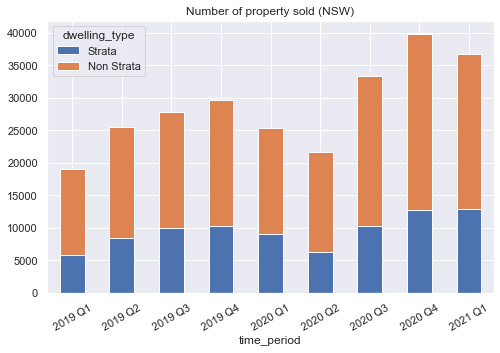

In [13]:
# Visualisation
sns.set_theme()
sales_num_plot = sales_num[['Strata', 'Non Strata']]


sales_num_plot.plot(kind='bar', stacked=True,
                    title = "Number of property sold (NSW)",
                    legend=True,
                    figsize=(8,5), 
                    rot=30)

**CR**: for the first dot point, the trend should be starting at Q3, not Q1. There is a decline in Q1 and Q2. 


#### B. <u>Total level trends - average house price</u> ####
Key observations:
* Total (Strata + non-Strata) average price has been **trending up since Q1 2020** despite COVID
* And this upward trend has been **driven by non-Strata houses**, the price of which have rocketed since Q2 2020
* Strata properties (more likely to be apartment units/condos, terrace houses with shared common areas) on the contrary saw moderate increase in price in Q2'20 to Q4 then falling flat

See [here](https://www.macquarie.com.au/home-loans/strata-properties-pros-and-cons.html) for more information on difference of Strata and non-strata property. 

**THIS IS IMPORTANT: suggesting that Strata and non-Strata house prices behave very diffirently and should probably be looked at separately in later regression analysis**

In [14]:
# Look at changes in average price
price_mean = s_master.groupby(['time_period', 'dwelling_type'])['mean_price'].mean().unstack()
price_mean.round(2)

dwelling_type,Non Strata,Strata,Total
time_period,,,
2019 Q1,849.25,750.89,795.19
2019 Q2,928.23,821.45,850.38
2019 Q3,966.24,841.71,887.02
2019 Q4,1016.61,795.46,887.63
2020 Q1,996.49,741.58,860.90
2020 Q2,965.07,783.63,870.92
2020 Q3,1024.44,767.19,887.17
2020 Q4,1070.68,779.69,916.88
2021 Q1,1152.36,794.78,954.89


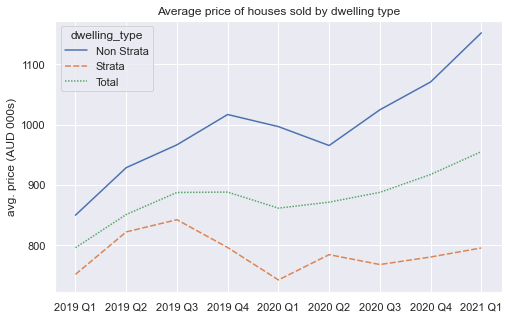

In [15]:
# Visualisation - avg. price line chart
plt.figure(figsize=(8,5))
ax = sns.lineplot(data=price_mean)
ax.set_title("Average price of houses sold by dwelling type")
ax.set_ylabel("avg. price (AUD 000s)")
ax.set_xlabel(None)
plt.show()

In [16]:
# Look at changes in median price to reduce the impact of potential outliers
price_median = s_master.groupby(['time_period', 'dwelling_type'])['median_price'].mean().unstack()
price_median.round(2)

dwelling_type,Non Strata,Strata,Total
time_period,,,
2019 Q1,803.41,691.19,736.71
2019 Q2,878.58,701.60,753.05
2019 Q3,907.23,737.43,783.48
2019 Q4,961.33,762.06,838.15
2020 Q1,940.69,712.01,805.46
2020 Q2,912.00,723.83,811.05
2020 Q3,966.09,717.77,815.35
2020 Q4,1004.87,723.77,838.91
2021 Q1,1095.24,735.75,869.54


Text(0.5, 0, '')

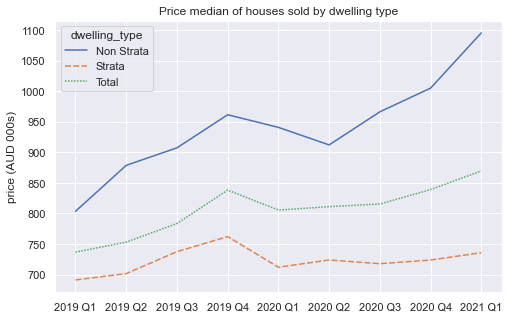

In [17]:
# Visualisation - median price line chart

plt.figure(figsize=(8,5))
ax = sns.lineplot(data=price_median)
ax.set_title("Price median of houses sold by dwelling type")
ax.set_ylabel("price (AUD 000s)")
ax.set_xlabel(None)

**CR** we want to find a way to get a map of sydney, link the postcodes, that way we can have a heatmap for better visualisation of sales around Sydney. Perhaps finding a website that gets the boundaries of the city with the post code. Is there a way to extract those boundaries? 

will have a look into this link : https://github.com/chrisberkhout/jvectormap_data_au

#### C. <u>Suburb level (Q1 2021) - hottest and most expensive suburbs</u> ####

**TO BE DONE:**
* Scrape a table somewhere online to map postcode to the name of suburbs
* Or make a decision to use the LGA tab of the raw data sheets (instead of the postcode sheet used here)
* Investigate map visualisation

In [18]:
# Group sales number by postcode
sales_pc = s_total.groupby(['postcode','time_period'])[['sales_no']].sum().unstack()
sales_pc.columns = sales_pc.columns.droplevel() #Drop column multiindex 
sales_pc = sales_pc.sort_values(by='2021 Q1', ascending=False)

# 10 areas with most sales in Q1 2021
sales_pc.head(10)

time_period,2019 Q1,2019 Q2,2019 Q3,2019 Q4,2020 Q1,2020 Q2,2020 Q3,2020 Q4,2021 Q1
postcode,,,,,,,,,
2250,196.0,245.0,268.0,273.0,236.0,199.0,341.0,418.0,397.0
2155,128.0,184.0,261.0,309.0,279.0,180.0,312.0,395.0,370.0
2540,162.0,243.0,207.0,249.0,212.0,183.0,319.0,361.0,351.0
2170,159.0,279.0,298.0,384.0,248.0,255.0,317.0,382.0,348.0
2650,214.0,223.0,254.0,277.0,267.0,205.0,339.0,401.0,346.0
2261,218.0,207.0,248.0,272.0,215.0,214.0,343.0,356.0,344.0
2560,179.0,205.0,213.0,246.0,219.0,191.0,279.0,316.0,337.0
2259,171.0,171.0,233.0,232.0,210.0,200.0,292.0,354.0,332.0
2145,140.0,206.0,225.0,241.0,243.0,167.0,233.0,348.0,330.0


Roughly:
* **2250**: part of Gosford LGA (Central Coast Region)
* **2155**: part of Cherrybrook LGA 
* **2540**: Culburra LGA (Illawara Region)
* **2170**: part of Liverpool LGA
* **2650**: part of Junee LGA (Murrumbidgee Region)
* **2251**: part of Wyong LGA (Central Coast Region)
* **2560**: part of Campbelltown LGA 
* **2259**: part of Wyong LGA (Central Coast Region)
* **2145**: part of Holroyd LGA 
* **2444**: part of Port Macquarie LGA (Mid North Coast Region)

Look at how the price in these areas has changed.

In [19]:
# Filter out top5 five postcode from the total dataset
s5_list = list(sales_pc.head(5).index)
s5 = s_total.loc[s_total['postcode'].isin(s5_list)]

# Check the average sales price of each pc
s5 = s5.groupby(['time_period','postcode'])['mean_price'].mean().unstack()

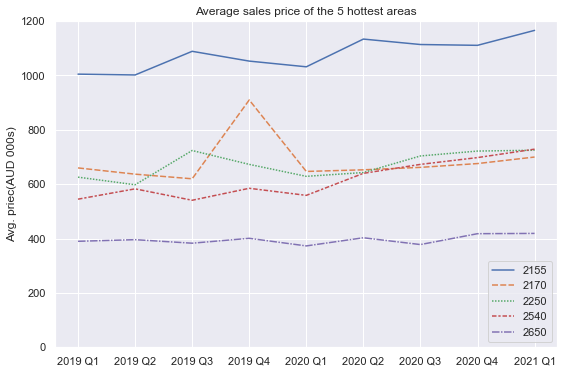

In [20]:
plt.figure(figsize=(9,6))
ax = sns.lineplot(data=s5)
ax.set_title("Average sales price of the 5 hottest areas")
ax.set_ylim(0,1200)
ax.set_ylabel("Avg. priec(AUD 000s)")
ax.set_xlabel(None)
ax.legend(loc=4)

Next, look at average price by postcode.

In [21]:
# Group price (total average) by postcode
price_pc = s_total.groupby(['postcode','time_period'])[['mean_price']].mean().unstack()
price_pc.columns = price_pc.columns.droplevel() #Drop column multiindex 
price_pc = price_pc.sort_values(by='2021 Q1', ascending=False)

# Top 5 most expensive areas in Q1 2021
price_pc.head(5)

time_period,2019 Q1,2019 Q2,2019 Q3,2019 Q4,2020 Q1,2020 Q2,2020 Q3,2020 Q4,2021 Q1
postcode,,,,,,,,,
2220,824.0,1001.0,889.0,999.0,891.0,958.0,989.0,1294.0,4291.0
2027,2575.0,3158.0,3069.0,2399.0,2166.0,2191.0,3657.0,3307.0,3808.0
2092,2521.0,2827.0,2895.0,2634.0,2614.0,2478.0,3176.0,3422.0,3677.0
2030,3193.0,3509.0,2851.0,3160.0,3150.0,3313.0,3277.0,3589.0,3658.0
2107,1830.0,1637.0,1706.0,1994.0,2191.0,1801.0,2114.0,2473.0,3045.0


They are:
* **2220:** Hurstville & Hurstville Grove
* **2027:** Waverly LGA - Darling Point, Edgecliff & Point Piper (in
* **2092:** Manly Warringah LGA - Seafort
* **2030:** Waverly LGA - Rose Bay North, Vaucluse, Watsons Bay
* **2107:** Manly Warringah LGA - NEWPORT BEACH, AVALON, AVALON BEACH, BILGOLA, CLAREVILLE, WHALE BEACH

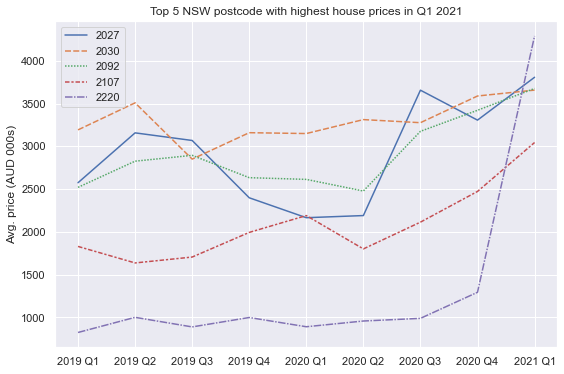

In [22]:
# Visualisation
price_pc5 = price_pc.head(5)
price_pc5_tr = price_pc5.transpose()

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=price_pc5_tr)
ax.set_title("Top 5 NSW postcode with highest house prices in Q1 2021")
#ax.set_ylim(0,500)
ax.set_ylabel("Avg. price (AUD 000s)")
ax.set_xlabel(None)
ax.legend(loc=0)

### 1-3 Join Census Data

1.3.1 <u><b>Personal Weekly Income</b></u>

In [23]:
# Read weekly income data
census_INCP = "Files/Census/POA (UR) by INCP Toal Personal Income (Weekly).csv"

incp_raw = pd.read_csv(census_INCP, skiprows=9, nrows=11142,
                       usecols=['POA (UR)', 'INCP Total Personal Income (weekly)', 'Count'])

# Rename column for easier referencing
incp_cols = {'POA (UR)':'postcode', 'INCP Total Personal Income (weekly)':'INCP_WK'}
incp_raw.rename(columns=incp_cols, inplace=True)

incp_raw.head()

,postcode,INCP_WK,Count
0,"2000, NSW",Negative income,204
1,"2000, NSW",Nil income,3297
2,"2000, NSW","$1-$149 ($1-$7,799)",502
3,"2000, NSW","$150-$299 ($7,800-$15,599)",1112
4,"2000, NSW","$300-$399 ($15,600-$20,799)",1978


In [24]:
incp = incp_raw.groupby(['postcode','INCP_WK'])['Count'].sum().unstack()
incp.head(1)

INCP_WK,"$1,000-$1,249 ($52,000-$64,999)","$1,250-$1,499 ($65,000-$77,999)","$1,500-$1,749 ($78,000-$90,999)","$1,750-$1,999 ($91,000-$103,999)","$1-$149 ($1-$7,799)","$150-$299 ($7,800-$15,599)","$2,000-$2,999 ($104,000-$155,999)","$3,000 or more ($156,000 or more)","$300-$399 ($15,600-$20,799)","$400-$499 ($20,800-$25,999)","$500-$649 ($26,000-$33,799)","$650-$799 ($33,800-$41,599)","$800-$999 ($41,600-$51,999)",Negative income,Nil income,Not applicable,Not stated,Total
postcode,,,,,,,,,,,,,,,,,,
"2000, NSW",1676,1028,977,677,502,1112,1456,1796,1978,2201,1915,1599,1638,204,3297,1251,4115,27411


In [25]:
# Remove the last row
incp = incp[:-1]

In [26]:
# Clean column names
income_cols= {'$1,000-$1,249 ($52,000-$64,999)' : '$1000-1249', 
            '$1,250-$1,499 ($65,000-$77,999)' : '$1250-1499',
            '$1,500-$1,749 ($78,000-$90,999)' : '$1500-1749 ', 
            '$1,750-$1,999 ($91,000-$103,999)': '$1750-1999',
            '$1-$149 ($1-$7,799)': '$1-149', 
            '$150-$299 ($7,800-$15,599)' : '$150-299',
            '$2,000-$2,999 ($104,000-$155,999)':'$2000-2999',
            '$3,000 or more ($156,000 or more)':'>=$3000', 
            '$300-$399 ($15,600-$20,799)':'$300-399',
            '$400-$499 ($20,800-$25,999)':'$400-499', 
            '$500-$649 ($26,000-$33,799)':'$500-649',
            '$650-$799 ($33,800-$41,599)':'$650-799', 
            '$800-$999 ($41,600-$51,999)':'$800-999',
             'Total':'INCP_TOTAL'}

incp.rename(columns=income_cols, inplace=True)

# Combine 'not applicable' and 'not stated' into one column
incp['INCP_na'] = incp['Not applicable'] + incp['Not stated']
incp = incp.drop(columns=['Not applicable', 'Not stated'], axis=1)
incp.head(1)

INCP_WK,$1000-1249,$1250-1499,$1500-1749,$1750-1999,$1-149,$150-299,$2000-2999,>=$3000,$300-399,$400-499,$500-649,$650-799,$800-999,Negative income,Nil income,INCP_TOTAL,INCP_na
postcode,,,,,,,,,,,,,,,,,
"2000, NSW",1676,1028,977,677,502,1112,1456,1796,1978,2201,1915,1599,1638,204,3297,27411,5366


In [27]:
# Remove 'NSW' in the index and cast postcode to int64
incp.reset_index(inplace=True)
incp['postcode'] = incp['postcode'].str.split(",", n=1, expand=True)
incp['postcode'] = incp['postcode'].astype('int64')
incp = incp.set_index('postcode')

In [28]:
# Reorder columns
cols = incp.columns.tolist()
cols = ['$1-149','$150-299','$300-399','$400-499','$500-649','$650-799',
        '$800-999','$1000-1249','$1250-1499','$1500-1749 ',
        '$1750-1999','$2000-2999','>=$3000',
        'Negative income','Nil income','INCP_na','INCP_TOTAL']

incp=incp[cols]

incp.head(1)

INCP_WK,$1-149,$150-299,$300-399,$400-499,$500-649,$650-799,$800-999,$1000-1249,$1250-1499,$1500-1749,$1750-1999,$2000-2999,>=$3000,Negative income,Nil income,INCP_na,INCP_TOTAL
postcode,,,,,,,,,,,,,,,,,
2000,502,1112,1978,2201,1915,1599,1638,1676,1028,977,677,1456,1796,204,3297,5366,27411


In [29]:
incp['INCP_LOW'] = incp.iloc[:, 0:6].sum(axis=1)
incp['INCP_MID'] = incp.iloc[:, 6:10].sum(axis=1)
incp['INCP_HIGH'] = incp.iloc[:, 10:13].sum(axis=1)
incp['INCP_NEG_NIL'] = incp.iloc[:, 13:15].sum(axis=1)

incp_gr = incp[['INCP_LOW', 'INCP_MID', 'INCP_HIGH', 'INCP_NEG_NIL', 'INCP_na', 'INCP_TOTAL']]

incp_gr.head(1)

INCP_WK,INCP_LOW,INCP_MID,INCP_HIGH,INCP_NEG_NIL,INCP_na,INCP_TOTAL
postcode,,,,,,
2000,9307,5319,3929,3501,5366,27411


**CR**: joining two DFs together, matching them by postcode. 

In [30]:
# Join INCP with sales data
s_join = s_master.join(incp_gr, on='postcode')
s_join.head()

,postcode,dwelling_type,median_price,mean_price,sales_no,Qdelta_median,Adelta_median,Qdelta_count,Adelta_count,key,time_period,year,quarter,INCP_LOW,INCP_MID,INCP_HIGH,INCP_NEG_NIL,INCP_na,INCP_TOTAL
0,2000,Total,1160.0,1348.0,103.0,-0.0169,-0.1375,-0.1043,-0.1488,s128,2019 Q1,2019,1,9307.0,5319.0,3929.0,3501.0,5366.0,27411.0
1,2000,Non Strata,680.0,720.0,5.0,NaN,NaN,NaN,NaN,s128,2019 Q1,2019,1,9307.0,5319.0,3929.0,3501.0,5366.0,27411.0
2,2000,Strata,1135.0,1322.0,101.0,-0.0340,-0.0920,-0.0734,-0.1062,s128,2019 Q1,2019,1,9307.0,5319.0,3929.0,3501.0,5366.0,27411.0
3,2007,Total,641.0,517.0,20.0,-0.0642,-0.1097,-0.1333,-0.3158,s128,2019 Q1,2019,1,2803.0,1458.0,718.0,2410.0,1447.0,8846.0
4,2007,Strata,641.0,517.0,20.0,-0.0642,-0.1097,-0.1333,-0.3158,s128,2019 Q1,2019,1,2803.0,1458.0,718.0,2410.0,1447.0,8846.0



<br>
1.3.2 <u><b>Household Size</b></u>

In [31]:
census_cprf = "Files/Census/POA by CPRF Count of Persons in Family by STATE.xlsx"
cprf = pd.read_excel(census_cprf, sheet_name="Data Sheet 0", skiprows=9, nrows=619)
cprf.head(5)

,CPRF Count of Persons in Family,Unnamed: 1,Two persons in family,Three persons in family,Four persons in family,Five persons in family,Six or more persons in family,Not applicable,Total
0,NaN,POA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"2000, NSW",3453.0,857.0,354.0,54.0,21.0,8125.0,12861.0
2,NaN,"2006, NSW",0.0,0.0,0.0,0.0,5.0,13.0,18.0
3,NaN,"2007, NSW",830.0,215.0,98.0,25.0,4.0,2524.0,3696.0
4,NaN,"2008, NSW",1308.0,243.0,105.0,17.0,7.0,3813.0,5493.0


In [32]:
# Remove redundant rows and columns 

cprf = cprf[1:] #remove the first row
cprf = cprf.drop(columns='CPRF Count of Persons in Family') # remove the first column

# Rename columns
cprf_cols= {'Unnamed: 1' : 'postcode', 
            'Two persons in family' : 'CPRF_2',
            'Three persons in family' : 'CPRF_3', 
            'Four persons in family': 'CPRF_4',
            'Five persons in family': 'CPRF_5', 
            'Six or more persons in family' : 'CPRF_6',
            'Not applicable':'CPRF_na',
            'Total' :'CPRF_FAM_NO'}
cprf.rename(columns=cprf_cols, inplace=True)

cprf.head(1)

,postcode,CPRF_2,CPRF_3,CPRF_4,CPRF_5,CPRF_6,CPRF_na,CPRF_FAM_NO
1,"2000, NSW",3453.0,857.0,354.0,54.0,21.0,8125.0,12861.0


In [36]:
# Remove 'NSW' in the index and cast postcode to int64
cprf.reset_index(inplace=True)
cprf['postcode'] = cprf['postcode'].str.split(",", n=1, expand=True)
cprf['postcode'] = cprf['postcode'].astype('int64')
cprf = cprf.set_index('postcode')
cprf = cprf.drop(columns='index', axis=1)

cprf.head(1)

,CPRF_2,CPRF_3,CPRF_4,CPRF_5,CPRF_6,CPRF_na,CPRF_FAM_NO
postcode,,,,,,,
2000,3453.0,857.0,354.0,54.0,21.0,8125.0,12861.0


In [37]:
# Join with sales data
s_join = s_join.join(cprf, on='postcode')
s_join.head()

,postcode,dwelling_type,median_price,mean_price,sales_no,Qdelta_median,Adelta_median,Qdelta_count,Adelta_count,key,...,INCP_NEG_NIL,INCP_na,INCP_TOTAL,CPRF_2,CPRF_3,CPRF_4,CPRF_5,CPRF_6,CPRF_na,CPRF_FAM_NO
0,2000,Total,1160.0,1348.0,103.0,-0.0169,-0.1375,-0.1043,-0.1488,s128,...,3501.0,5366.0,27411.0,3453.0,857.0,354.0,54.0,21.0,8125.0,12861.0
1,2000,Non Strata,680.0,720.0,5.0,NaN,NaN,NaN,NaN,s128,...,3501.0,5366.0,27411.0,3453.0,857.0,354.0,54.0,21.0,8125.0,12861.0
2,2000,Strata,1135.0,1322.0,101.0,-0.0340,-0.0920,-0.0734,-0.1062,s128,...,3501.0,5366.0,27411.0,3453.0,857.0,354.0,54.0,21.0,8125.0,12861.0
3,2007,Total,641.0,517.0,20.0,-0.0642,-0.1097,-0.1333,-0.3158,s128,...,2410.0,1447.0,8846.0,830.0,215.0,98.0,25.0,4.0,2524.0,3696.0
4,2007,Strata,641.0,517.0,20.0,-0.0642,-0.1097,-0.1333,-0.3158,s128,...,2410.0,1447.0,8846.0,830.0,215.0,98.0,25.0,4.0,2524.0,3696.0


# 2. Rent data

<u>USAGE POTENTIALS:</u>
1. Analyse correlation of rental price and sales price 

In [ ]:
rent = "Files/Rent/Issue-135-Rent-tables-March-2021-quarter.xlsx"
rent_pc = pd.read_excel(rent, sheet_name="Postcode", na_values='-', header=7)

In [ ]:
# Rename column for easier referencing (rent)

rename_cols= {'Postcode':'postcode', 
             'Dwelling Types':'dwelling_type', 
              'Number of Bedrooms':'bed_number',
             'First Quartile Weekly Rent for New Bonds\n$': '25%_wrent_newb',
             'Median Weekly Rent for New Bonds\n$': '50%_wrent_newb', 
             'Third Quartile Weekly Rent for New Bonds\n$': "75%_wrent_newb",
             'New Bonds Lodged\nNo.' : 'new_bonds_number',
              'Total Bonds Held\nNo.': 'total_bonds_number',
             'Sales\nNo.':'sales_number'}

rent_pc.rename(columns=rename_cols,inplace=True)
rent_pc.head(5)

In [ ]:
# Check data types
rent_pc.dtypes

In [ ]:
rent_pc.loc[rent_pc['new_bonds_number'] == 's', 'new_bonds_number'] = 20.0
rent_pc.loc[rent_pc['total_bonds_number'] == 's', 'total_bonds_number'] = 20.0

rent_pc['new_bonds_number'] = rent_pc['new_bonds_number'].astype(float)
rent_pc['total_bonds_number'] = rent_pc['total_bonds_number'].astype(float)

# Check data types again
rent_pc.dtypes

In [ ]:
# Check unique values of dwelling type
rent_pc.groupby('dwelling_type').size()

In [ ]:
# Check unique values of bed_number
rent_pc.groupby('bed_number').size()

In [ ]:
# checking shape of rent_pc and null values

print(rent_pc.shape, "\n")
print(rent_pc.isnull().sum())

In [ ]:
# Check top 20 postcodes that have higest total bond number in Q1 2021
tbonds_pc = rent_pc.groupby(["postcode", "dwelling_type"])['total_bonds_number'].sum().unstack()

tbonds_pc.sort_values(by="Total", ascending = False).head(20)

In [ ]:
nbonds_pc = rent_pc.groupby(["postcode", "dwelling_type"])['new_bonds_number'].sum().unstack()
nbonds_pc.sort_values(by='Total', ascending = False).head(20)